In [45]:
import pandas as pd

In [46]:
## Reading required files

user_gameplay = pd.read_csv('user_gameplay_data.csv')
deposits = pd.read_csv("Deposits.csv")
Withdrawals = pd.read_csv("Withdrawal.csv")

In [47]:
## Displaying 1st 5 records from each data file
print("Games played:")
print(user_gameplay.head())

print("\nDeposits:")
print(deposits.head())

print("\nWithdrawals:")
print(Withdrawals.head())

Games played:
   User ID  Games Played         Datetime
0      851             1  01-10-2022 0:00
1      717             1  01-10-2022 0:00
2      456             1  01-10-2022 0:00
3      424             1  01-10-2022 0:00
4      845             1  01-10-2022 0:00

Deposits:
   User Id         Datetime  Amount
0      357  01-10-2022 0:03    2000
1      776  01-10-2022 0:03    2500
2      492  01-10-2022 0:06    5000
3      803  01-10-2022 0:07    5000
4      875  01-10-2022 0:09    1500

Withdrawals:
   User Id         Datetime  Amount
0      190  01-10-2022 0:03    5872
1      159  01-10-2022 0:16    9540
2      164  01-10-2022 0:24     815
3      946  01-10-2022 0:29   23000
4      763  01-10-2022 0:40    9473


In [48]:
deposits.rename(columns={'User Id': 'User_Id'}, inplace=True)
Withdrawals.rename(columns={'User Id': 'User_Id'}, inplace=True)
user_gameplay.rename(columns={'User ID': 'User_Id'}, inplace=True)

## Part A: Calculating Loyalty Points

#### 1)Playerwise Loyalty points  earned by players on given month and slot


In [49]:
## Converting Datetime columns to Datetime format

user_gameplay['Datetime'] = pd.to_datetime(user_gameplay['Datetime'], dayfirst=True)
deposits['Datetime'] = pd.to_datetime(deposits['Datetime'], dayfirst=True)
Withdrawals['Datetime'] = pd.to_datetime(Withdrawals['Datetime'], dayfirst=True)

In [50]:
## Creating a function to calculate loyalty points for a given month and slot.

from datetime import datetime

def loyalty_points(date_str, slot, gameplay_data, deposit_data, withdrawal_data):



  # Converting all Datetime columns
  deposits['Datetime'] = pd.to_datetime(deposits['Datetime'], dayfirst=True)
  Withdrawals['Datetime'] = pd.to_datetime(Withdrawals['Datetime'], dayfirst=True)
  user_gameplay['Datetime'] = pd.to_datetime(user_gameplay['Datetime'], dayfirst=True)

  # Converting input date
  target_date = pd.to_datetime(date_str, dayfirst=True)

  # Filtering rows for that specific date
  df_deposit_day = deposits[deposits['Datetime'].dt.date == target_date.date()]
  df_withdrawal_day = Withdrawals[Withdrawals['Datetime'].dt.date == target_date.date()]
  df_games_day = user_gameplay[user_gameplay['Datetime'].dt.date == target_date.date()]

  ## Filtering data with slot

  def slot_filter(df, slot):
    if slot == 'S1':
      return df[df['Datetime'].dt.hour < 12]
    elif slot == 'S2':
      return df[df['Datetime'].dt.hour >= 12]
    else:
      raise ValueError('Slot must be either "S1" or "S2"')


  ## Applying slot function

  gameplay_slot = slot_filter(df_games_day, slot)
  deposite_slot = slot_filter(df_deposit_day, slot)
  withdrawal_slot = slot_filter(df_withdrawal_day, slot)

  ## Aggregating amount of deposits, withdrawals and games count

  deposit_sum  = deposite_slot.groupby('User_Id')['Amount'].sum().rename('Deposit_Amount')
  withdrawal_sum = withdrawal_slot.groupby('User_Id')['Amount'].sum().rename('Withdrawal_Amount')
  Deposit_count = deposite_slot.groupby('User_Id').size().rename('NumDeposits')
  withdrawal_count = withdrawal_slot.groupby('User_Id').size().rename('NumWithdrawals')
  games_count = gameplay_slot.groupby('User_Id').size().rename('NumGames')

  ## Merging all metrics

  loyalty_df = pd.concat([deposit_sum, withdrawal_sum, Deposit_count, withdrawal_count, games_count], axis = 1).fillna(0)

  ## Calculating Loyalty Points

  loyalty_df['Loyalty_Points'] = ((0.01 * loyalty_df['Deposit_Amount']) + (0.005 * loyalty_df['Withdrawal_Amount']) + (0.001 * (loyalty_df['NumDeposits'] - loyalty_df['NumWithdrawals']).clip(lower = 0)) +
                                  (0.2 * loyalty_df['NumGames']))

  return loyalty_df[['Loyalty_Points']].sort_values(by = 'Loyalty_Points', ascending = False)





#### a) Playerwise loyalty points for 2nd October and slot S1

In [51]:
Result1 = loyalty_points('02-october-2022', 'S1', user_gameplay, deposits, Withdrawals)
Result1.head()

,Loyalty_Points
User_Id,
634,1478.355
672,1300.000
566,1250.406
949,677.500
446,550.202


#### b) Playerwise loyalty pointy points for 16th october slot S2

In [52]:
Result2 = loyalty_points('16-october-2022', 'S2', user_gameplay, deposits, Withdrawals)
Result2.head()

,Loyalty_Points
User_Id,
634,1491.555
212,999.991
99,980.002
28,900.004
566,880.203


#### c) Playerwise loyalty points for 18th October slot S2

In [53]:
Result3 = loyalty_points('18-october-2022', 'S1', user_gameplay, deposits, Withdrawals)
Result3.head()

,Loyalty_Points
User_Id,
634,2723.100
208,1701.401
673,900.801
162,770.000
245,750.000


#### d) Playerwise loyalty points for 26th october slot s2

In [54]:
Result4 = loyalty_points('26-october-2022', 'S2', user_gameplay, deposits, Withdrawals)
Result4.head()

,Loyalty_Points
User_Id,
714,2000.001
369,1501.915
634,1237.010
538,1200.403
2,900.002


### 2) Overall Loyalty Points and Player Ranking for October


In [55]:
def calculate_monthly_loyalty_points(month_name, df_deposit, df_withdrawal, df_games):
    # Converting datetime columns
    df_deposit['Datetime'] = pd.to_datetime(deposits['Datetime'], dayfirst=True)
    df_withdrawal['Datetime'] = pd.to_datetime(Withdrawals['Datetime'], dayfirst=True)
    df_games['Datetime'] = pd.to_datetime(user_gameplay['Datetime'], dayfirst=True)

    # Converting month name to month number
    month_number = pd.to_datetime("01 " + month_name + " 2022", dayfirst=True).month

    # Filtering data for the month
    deposit_oct = deposits[deposits['Datetime'].dt.month == month_number]
    withdrawal_oct = Withdrawals[Withdrawals['Datetime'].dt.month == month_number]
    games_oct = user_gameplay[user_gameplay['Datetime'].dt.month == month_number]

    # Grouping and aggregating the data
    deposit_sum = deposit_oct.groupby('User_Id')['Amount'].sum().rename('DepositAmount')
    withdrawal_sum = withdrawal_oct.groupby('User_Id')['Amount'].sum().rename('WithdrawalAmount')
    games_count = games_oct.groupby('User_Id').size().rename('NumGames')

    # Merging all data
    loyalty_df = pd.concat([deposit_sum, withdrawal_sum, games_count], axis=1).fillna(0)

    # creating & applying Loyalty formula
    loyalty_df['LoyaltyPoints'] = (
        0.01 * loyalty_df['DepositAmount'] +
        0.005 * loyalty_df['WithdrawalAmount'] +
        0.001 * (loyalty_df['DepositAmount'] - loyalty_df['WithdrawalAmount']).clip(lower=0) +
        0.2 * loyalty_df['NumGames']
    )

    # Ranking: 1st by LoyaltyPoints, 2nd by NumGames (both descending)
    loyalty_df['Rank'] = loyalty_df.sort_values(['LoyaltyPoints', 'NumGames'], ascending=False).rank(
        method='dense', ascending=False)['LoyaltyPoints']

    # Sorting for final output
    loyalty_df = loyalty_df.sort_values(['LoyaltyPoints', 'NumGames'], ascending=False)

    return loyalty_df[['LoyaltyPoints', 'NumGames', 'Rank']]


In [56]:
## Applying the function on Data

october_loyalty = calculate_monthly_loyalty_points("October", deposits, Withdrawals, user_gameplay)
print(october_loyalty.head(10))  # top 10 users


         LoyaltyPoints  NumGames  Rank
User_Id                               
634          83843.325        24   1.0
672          24682.700        10   2.0
99           23665.705        10   3.0
212          23534.391         1   4.0
566          20787.809       183   5.0
740          20584.942         2   6.0
714          18440.500         6   7.0
421          15446.445      1557   8.0
30           15230.180        13   9.0
222          14534.432        10  10.0


### 3) Average Deposite Amount

In [57]:
average_deposit = deposits['Amount'].mean()
print(f"Overall Average Deposit Amount: ₹{average_deposit:.2f}")


Overall Average Deposit Amount: ₹5492.19


### 4) Average Deposit Amount per user in a month

In [58]:
def average_monthly_deposit_per_user(month_name, df_deposit):
    # Ensure Datetime is parsed
    deposits['Datetime'] = pd.to_datetime(deposits['Datetime'], dayfirst=True)

    # Convert month name to number
    month_number = pd.to_datetime("01 " + month_name + " 2022", dayfirst=True).month

    # Filter only October deposits
    df_month = deposits[deposits['Datetime'].dt.month == month_number]

    # Group by user to get total deposited by each user
    user_totals = df_month.groupby('User_Id')['Amount'].sum()

    # Now average across users
    avg_per_user = user_totals.mean()

    return avg_per_user


Average Deposit Amount Per User in October

In [59]:
oct_avg = average_monthly_deposit_per_user("October", deposits)
print(f"Average deposit amount per user in October: ₹{oct_avg:.2f}")


Average deposit amount per user in October: ₹104669.65


### 5) Average Number of Games Played Per User

In [60]:
def average_games_played_per_user(user_gameplay):
    # Make sure Datetime is parsed
    user_gameplay['Datetime'] = pd.to_datetime(user_gameplay['Datetime'], dayfirst=True)

    # Count number of games per user
    games_per_user = user_gameplay.groupby('User_Id').size()

    # Take average across all users
    avg_games = games_per_user.mean()

    return avg_games


In [61]:
avg_games = average_games_played_per_user(user_gameplay)
print(f"Average number of games played per user: {avg_games:.2f}")


Average number of games played per user: 355.27


## Part B: Bonus Distribution Strategy for Top 50 Loyalty Players

I have chosen to distribute the Rs 50000 bonus **proportional to the loyalty points**, since the loyalty points already accounts for deposit behaviour, withdrawal activity and game participation. This method insures fair, performance-based bonus allocation.

In [62]:
## We have already calculated loyalty points for the month of october.

october_loyalty.head()

,LoyaltyPoints,NumGames,Rank
User_Id,,,
634,83843.325,24,1.0
672,24682.700,10,2.0
99,23665.705,10,3.0
212,23534.391,1,4.0
566,20787.809,183,5.0


Now, creating a function to extract top 50 players by ranking and then, distributing the bonus based on the contributed proportion of their loyalty points.

In [63]:
def distribute_bonus(top_n=50, total_bonus=50000, loyalty_df=None):
    # Get top N players
    top_players = loyalty_df.head(top_n).copy()

    # Total loyalty points of top 50
    total_loyalty = top_players['LoyaltyPoints'].sum()

    # Bonus allocation (proportional to loyalty points)
    top_players['Bonus'] = (top_players['LoyaltyPoints'] / total_loyalty) * total_bonus

    return top_players[['LoyaltyPoints', 'NumGames', 'Bonus']].sort_values(by='Bonus', ascending=False)


In [64]:
## applying the function

bonus_df = distribute_bonus(top_n=50, total_bonus=50000, loyalty_df=october_loyalty)
print(bonus_df.head(10))  # Top 10 bonus earners


         LoyaltyPoints  NumGames        Bonus
User_Id                                      
634          83843.325        24  6399.796285
672          24682.700        10  1884.040879
99           23665.705        10  1806.413223
212          23534.391         1  1796.389970
566          20787.809       183  1586.742210
740          20584.942         2  1571.257287
714          18440.500         6  1407.571126
421          15446.445      1557  1179.033648
30           15230.180        13  1162.526049
222          14534.432        10  1109.419312


##### Visualizing the bonus distribution

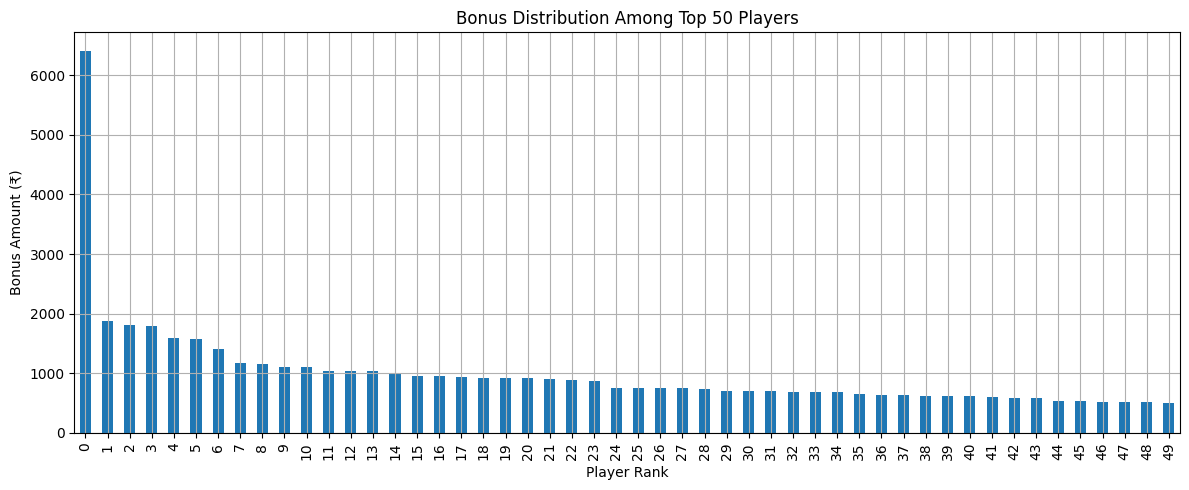

In [65]:
import matplotlib.pyplot as plt

bonus_df['Bonus'].reset_index(drop=True).plot(kind='bar', figsize=(12,5))
plt.title("Bonus Distribution Among Top 50 Players")
plt.xlabel("Player Rank")
plt.ylabel("Bonus Amount (₹)")
plt.grid(True)
plt.tight_layout()
plt.show()


## Part C: Evaluating and Improving the Loyalty Formula
Current loyalty points formula is

Loyalty Points =0.01 * DepositAmount + 0.005 * WithdrawalAmount + 0.001 * max(DepositAmount - WithdrawalAmount, 0) + 0.2 * NumGames

This rewards:

Deposits (1%) = strong incentive

Withdrawals (0.5%) = mild reward

Net deposit bonus (0.1%) = only if more deposit than withdrawal

Games played (0.2 per game) = fixed reward



**Pros:**

*   This formula balances monetary & activity based behaviour which encourages both transactions & engagement.
*   Prevents the gaming system i.e. Users who just deposite & withdraw repeatedly dont benefit unfairly due to the net-deposit bonus.
*   Overall this formula is simple & easy to compute.

**Cons:**


*   Rewarding withdrawals even mildly could churn or abuse.
*   Rich users with huge deposits might dominate, even with minimal engagement.


** Suggested Improvements:**



*   Remove or reduce withdrawal reward.
*   We can add time weighting i.e. Reward users who are consistently active over the month.
*   Introduce normalization to avoid rich-user domination.

These adjustments would make the loyalty system more **robust**, **engaging**, and **fair** across different player types.


** After suggested improvements the loyalty points formula should look like:**


**Loyalty Points** =
    (0.008 * DepositAmount) +
    (0.001 * WithdrawalAmount) +
    (0.002 * max(deposit - withdrawal, 0)) +
    (0.25 * NumGames) +
    (2 * ActiveDays)




*   0.008 * deposit : Slightly reduced from 0.01 to reduce rich user's domination.
*   0.001 * Withdrawal : This still acknowledges withdrawals, but discourages abuse.
*   0.002 * max(deposit - withdrawal, 0) : This encourages actual spending instead of recycling money.
*   0.25 * Num of games : Increased from 0.2 to emphasis gameplay.
*   2 * Active  days : Encourages consistency of players over time.





    

















## Simulating the improved loyalty formula :

To validate the fairness and effectiveness of the suggested improvements, I have implemented the revised loyalty formula and recalculate player rankings and bonus distribution for october.

This simulation will help to evaluate how the new formula impacts top players, balances monetary contribution and engagement, and encourages consistent play.



In [66]:
# Recalculating loyalty points using improved formula for October

# Step 1: Filtering October
deposits['Datetime'] = pd.to_datetime(deposits['Datetime'], dayfirst=True)
Withdrawals['Datetime'] = pd.to_datetime(Withdrawals['Datetime'], dayfirst=True)
user_gameplay['Datetime'] = pd.to_datetime(user_gameplay['Datetime'], dayfirst=True)

month_number = 10
deposit_oct = deposits[deposits['Datetime'].dt.month == month_number]
withdrawal_oct = Withdrawals[Withdrawals['Datetime'].dt.month == month_number]
games_oct = user_gameplay[user_gameplay['Datetime'].dt.month == month_number]

# Step 2: Grouping values
deposit_sum = deposit_oct.groupby('User_Id')['Amount'].sum().rename('DepositAmount')
withdrawal_sum = withdrawal_oct.groupby('User_Id')['Amount'].sum().rename('WithdrawalAmount')
net_deposit = (deposit_sum - withdrawal_sum).clip(lower=0).rename('NetDeposit')
games_count = games_oct.groupby('User_Id').size().rename('NumGames')

# Step 3: finding Active days
activity_dates = pd.concat([
    deposit_oct[['User_Id', 'Datetime']],
    withdrawal_oct[['User_Id', 'Datetime']],
    games_oct[['User_Id', 'Datetime']]
])
activity_dates['DateOnly'] = activity_dates['Datetime'].dt.date
active_days = activity_dates.groupby('User_Id')['DateOnly'].nunique().rename('ActiveDays')

# Step 4: Combining all data
loyalty_df_improved = pd.concat([
    deposit_sum, withdrawal_sum, net_deposit, games_count, active_days
], axis=1).fillna(0)

# Step 5: Applying new formula
loyalty_df_improved['LoyaltyPoints'] = (
    0.008 * loyalty_df_improved['DepositAmount'] +
    0.001 * loyalty_df_improved['WithdrawalAmount'] +
    0.002 * loyalty_df_improved['NetDeposit'] +
    0.25 * loyalty_df_improved['NumGames'] +
    2 * loyalty_df_improved['ActiveDays']
)

# Step 6: Showing  Top 10 players
loyalty_df_improved[['LoyaltyPoints', 'NumGames', 'ActiveDays']].sort_values(
    by='LoyaltyPoints', ascending=False
).head(10)


,LoyaltyPoints,NumGames,ActiveDays
User_Id,,,
672,21405.750,10,25
634,19921.705,24,29
212,18702.210,1,21
566,18114.429,183,31
740,17082.112,2,31
714,13459.900,6,24
30,13195.105,13,27
222,12793.142,10,20
99,11780.041,10,28


### Final Reflection

I explored multiple versions of the loyalty formula to balance monetary input and user engagement.

While my improved formula reduced bias toward pure depositors, simulation results showed that deposit-heavy users still dominated the top ranks. Even highly active players with 300+ games ranked below users who made fewer but larger deposits.

This reveals a key insight: any loyalty formula should carefully tune deposit vs. engagement weight to prevent imbalance. A possible future enhancement could be to apply percentile-based scoring or caps to avoid outliers influencing rankings unfairly.

For this assignment, I conclude with my improvement suggestions and one simulation to support the analysis.
